In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [408]:
teams.find_teams_by_city('Memphis')

[{'id': 1610612763,
  'full_name': 'Memphis Grizzlies',
  'abbreviation': 'MEM',
  'nickname': 'Grizzlies',
  'city': 'Memphis',
  'state': 'Tennessee',
  'year_founded': 1995}]

In [424]:
from nba_api.stats.static import teams

teamIds = dict([(team['abbreviation'], team['id']) for team in teams.get_teams()])

# # get all team abbreviations since 1983 associated with each team ID (takes a few minutes to run)

# from nba_api.stats.endpoints import leaguegamefinder
# import time

# teamAbbrevsDict = dict()

# for teamAbbrev in teamIds.keys():
#     allGamesDf = leaguegamefinder.LeagueGameFinder(team_id_nullable=teamIds[teamAbbrev]) \
#                                  .get_data_frames()[0]
    
#     teamAbbrevsDict[int(allGamesDf['TEAM_ID'].unique())] = list(allGamesDf['TEAM_ABBREVIATION'].unique())
    
#     time.sleep(1)

teamAbbrevsDict = {1610612737: ['ATL'], 1610612738: ['BOS'], 1610612739: ['CLE'], 1610612740: ['NOP', 'NOH', 'NOK']
                   , 1610612741: ['CHI'], 1610612742: ['DAL'], 1610612743: ['DEN'], 1610612744: ['GSW', 'GOS']
                   , 1610612745: ['HOU'], 1610612746: ['LAC', 'SDC'], 1610612747: ['LAL'], 1610612748: ['MIA']
                   , 1610612749: ['MIL'], 1610612750: ['MIN'], 1610612751: ['BKN', 'NJN'], 1610612752: ['NYK']
                   , 1610612753: ['ORL'], 1610612754: ['IND'], 1610612755: ['PHI', 'PHL'], 1610612756: ['PHX']
                   , 1610612757: ['POR'], 1610612758: ['SAC', 'KCK'], 1610612759: ['SAS', 'SAN'], 1610612760: ['OKC', 'SEA']
                   , 1610612761: ['TOR'], 1610612762: ['UTA', 'UTH'], 1610612763: ['MEM', 'VAN'], 1610612764: ['WAS']
                   , 1610612765: ['DET'], 1610612766: ['CHA', 'CHH']
                  }

teamIds

{'ATL': 1610612737,
 'BOS': 1610612738,
 'CLE': 1610612739,
 'NOP': 1610612740,
 'CHI': 1610612741,
 'DAL': 1610612742,
 'DEN': 1610612743,
 'GSW': 1610612744,
 'HOU': 1610612745,
 'LAC': 1610612746,
 'LAL': 1610612747,
 'MIA': 1610612748,
 'MIL': 1610612749,
 'MIN': 1610612750,
 'BKN': 1610612751,
 'NYK': 1610612752,
 'ORL': 1610612753,
 'IND': 1610612754,
 'PHI': 1610612755,
 'PHX': 1610612756,
 'POR': 1610612757,
 'SAC': 1610612758,
 'SAS': 1610612759,
 'OKC': 1610612760,
 'TOR': 1610612761,
 'UTA': 1610612762,
 'MEM': 1610612763,
 'WAS': 1610612764,
 'DET': 1610612765,
 'CHA': 1610612766}

In [315]:
standardStats = ["FGM","FGA","FG_PCT","FG3M","FG3A","FG3_PCT","FTM","FTA","FT_PCT"
                 ,"PTS","OREB","DREB","REB","AST","TOV","STL","BLK","PF","PLUS_MINUS"
                ]
advancedStats = ["OFF_RATING","DEF_RATING","NET_RATING"
                 ,"AST_PCT","AST_TO","AST_RATIO","TM_TOV_PCT"
                 ,"OREB_PCT","DREB_PCT","REB_PCT"
                 , "EFG_PCT", "TS_PCT", "PACE", "POSS"
                ]
    

In [464]:
def convert_season_str(withoutDashStr):
    nextSeasonStr = str(int(withoutDashStr[-2:]) + 1)
    
    if len(nextSeasonStr) < 2: # add 0 to beginning for seasons in 2000s
        nextSeasonStr = '0' + nextSeasonStr
    elif len(nextSeasonStr) == 3: # I think only to account for season 1999-00
        nextSeasonStr = nextSeasonStr[-2:]

    withDashStr = withoutDashStr + '-' + nextSeasonStr

    return withDashStr

def filter_regSeason_games(seasonStr, lowestWinPct, allSeasonGames):
    # get standings of every team that season
    seasonStandings = leaguestandings.LeagueStandings(season=seasonStr).get_data_frames()[0]

    # filter for IDs of only teams greater than lowestWinPct
    teamsToUseIds = seasonStandings[seasonStandings['WinPCT'] >= lowestWinPct]['TeamID'].to_list()

    # convert IDs to all possible corresponding abbreviations of teams
    allAbbrevs = [teamAbbrevsDict[teamId] for teamId in teamsToUseIds]
    teamsToUseAbbrevs = list(itertools.chain.from_iterable(allAbbrevs))

    filteredGames = allSeasonGames[allSeasonGames['MATCHUP'].apply(lambda matchupStr: matchupStr[-3:] in teamsToUseAbbrevs)]
    
    return filteredGames

In [483]:
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.endpoints import leaguedashteamstats
from nba_api.stats.endpoints import leaguestandings
import itertools
import time

allTeamAbbrevs = list(teamIds.keys())
allYearsStrs = [str(seasonInt) for seasonInt in np.arange(1983, 2022)]
colNames = ['TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GP'] + standardStats
lowestWinPct = 0.500 # filter games to only against teams greater than this win percentage

seasonStats = dict.fromkeys(allYearsStrs, pd.DataFrame(columns=colNames))
playoffStats = dict.fromkeys(allYearsStrs, pd.DataFrame(columns=colNames))

for teamAbbrev in allTeamAbbrevs:

    for seasonType in ['Regular Season', 'Playoffs']:
            
        if seasonType == 'Regular Season':
            seasonIdSuffix = '2' # arbitrary code used in nba data to denote regular season games
        elif seasonType == 'Playoffs':
            seasonIdSuffix = '4'
    
        # get data for all games the franchise has played (since 1983)
        allGamesDf = leaguegamefinder.LeagueGameFinder(team_id_nullable=teamIds[teamAbbrev], season_type_nullable=seasonType) \
                               .get_data_frames()[0]

        for yearStr in allYearsStrs:

            seasonStr = convert_season_str(yearStr) # need to use different format for some functions
            currSeasonGames = allGamesDf[allGamesDf['SEASON_ID']==seasonIdSuffix+yearStr]
            
            if not currSeasonGames.empty: # skip teams that didn't make the playoffs or didn't exist that season
                # for regular season games:
                # get league standings for that season and filter out games (eg. played against non-playoff teams)
                if seasonType == 'Regular Season':
                    currSeasonGames = filter_regSeason_games(seasonStr, lowestWinPct, currSeasonGames)
                
                time.sleep(1) # pause to avoid timeouts
                
                # do mean across all games played
                perGameStats = currSeasonGames[standardStats].apply(np.nanmean)
                perGameStats = pd.concat([allGamesDf.iloc[0][['TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME']], perGameStats])
                perGameStats['GP'] = currSeasonGames.shape[0] # store number of games played that season
                
                # get advanced stats if available (starting 1997 season)
                if int(yearStr) >= 1997:
                    temp = leaguedashteamstats.LeagueDashTeamStats(season=seasonStr, team_id_nullable=teamIds[teamAbbrev]
                                                                   , measure_type_detailed_defense='Advanced', season_type_all_star=seasonType
                                                                  )
                    advancedDf = temp.get_data_frames()[0][['TEAM_NAME', 'TEAM_ID'] + advancedStats]

                    # concat standard and advanced stats into one table
                    perGameStats = pd.concat([perGameStats, advancedDf[advancedDf['TEAM_ID']==perGameStats['TEAM_ID']][advancedStats].squeeze()])
                    perGameStats['POSS'] = perGameStats['POSS']/perGameStats['GP'] # get per game posessions

                # store regular season and playoffs separately
                if seasonType == 'Regular Season':
                    seasonStats[yearStr] = seasonStats[yearStr].append(perGameStats, ignore_index=True)
                elif seasonType == 'Playoffs':
                    playoffStats[yearStr] = playoffStats[yearStr].append(perGameStats, ignore_index=True)


C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty

C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty

C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty

C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty

C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty

C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
C:\Users\Mike\anaconda3\lib\site-packages\pandas\core\apply.py:290: RuntimeWarning: Mean of empty

In [ ]:
saveDir = 
saveFName = 'perGameStats'

import json
with open(filename, 'wb') as outfile:
    json.dump(data, outfile)

In [293]:
seasonStats['1997'].columns

Index(['TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GP', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'PTS',
       'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'PLUS_MINUS',
       'AST_PCT', 'AST_RATIO', 'AST_TO', 'DEF_RATING', 'DREB_PCT', 'EFG_PCT',
       'NET_RATING', 'OFF_RATING', 'OREB_PCT', 'PACE', 'POSS', 'REB_PCT',
       'TM_TOV_PCT', 'TS_PCT'],
      dtype='object')

In [452]:
seasonStats['2001']

,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GP,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,DREB_PCT,EFG_PCT,NET_RATING,OFF_RATING,OREB_PCT,PACE,POSS,REB_PCT,TM_TOV_PCT,TS_PCT
0,1610612737,ATL,Atlanta Hawks,51,35.196078,81.078431,0.434941,5.039216,14.862745,0.341588,...,0.689,0.471,-4.4,100.4,0.297,93.21,150.549020,0.491,0.166,0.517
1,1610612738,BOS,Boston Celtics,46,35.000000,81.913043,0.428217,8.586957,24.000000,0.356326,...,0.695,0.476,2.2,102.1,0.272,93.60,168.217391,0.481,0.144,0.520
2,1610612739,CLE,Cleveland Cavaliers,51,35.137255,79.764706,0.440667,4.725490,12.764706,0.364569,...,0.690,0.477,-3.6,103.4,0.319,91.31,148.098039,0.505,0.158,0.524
3,1610612741,CHI,Chicago Bulls,50,33.780000,77.980000,0.433840,3.540000,10.320000,0.328280,...,0.685,0.456,-9.1,97.2,0.298,91.56,150.980000,0.487,0.166,0.499
4,1610612742,DAL,Dallas Mavericks,46,38.434783,83.869565,0.459304,7.826087,21.304348,0.371239,...,0.683,0.507,4.3,110.3,0.285,94.36,170.065217,0.487,0.127,0.553
5,1610612743,DEN,Denver Nuggets,50,35.040000,84.000000,0.419040,5.440000,15.980000,0.342560,...,0.668,0.455,-6.3,100.3,0.341,91.35,150.740000,0.497,0.160,0.495
6,1610612744,GSW,Golden State Warriors,50,36.980000,85.660000,0.433120,4.160000,12.440000,0.333120,...,0.669,0.452,-5.6,101.5,0.373,95.75,157.800000,0.516,0.175,0.499
7,1610612745,HOU,Houston Rockets,50,33.860000,79.720000,0.426180,6.660000,18.960000,0.345980,...,0.675,0.465,-5.4,101.6,0.327,89.56,149.120000,0.497,0.155,0.507
8,1610612746,LAC,LA Clippers,50,35.480000,81.280000,0.438740,5.140000,14.320000,0.349400,...,0.673,0.476,-0.4,104.3,0.349,91.21,150.480000,0.512,0.161,0.519
9,1610612747,LAL,Los Angeles Lakers,46,37.478261,83.239130,0.451717,5.891304,17.521739,0.333674,...,0.686,0.498,7.6,108.0,0.311,93.32,167.195652,0.501,0.135,0.534


In [354]:
# parse to get regSeason stats of only those teams that made playoffs that season
playoffTeams = playoffStats['2001']['TEAM_NAME'].to_list()
regSeasonParsed = seasonStats['2001'][seasonStats['2001']['TEAM_NAME'].apply(lambda teamName: teamName in playoffTeams)]

# subtract regSeason stats from playoffs
pMinusR = playoffStats['2001'][standardStats + advancedStats] - regSeasonParsed[standardStats + advancedStats].reset_index(drop=True)

In [355]:
pMinusR

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,PTS,...,AST_TO,AST_RATIO,TM_TOV_PCT,OREB_PCT,DREB_PCT,REB_PCT,EFG_PCT,TS_PCT,PACE,POSS
0,-1.967988,-3.647866,-0.005511,-0.649390,-0.794207,-0.024127,-0.518293,-0.964939,0.022601,-5.103659,...,-0.22,-1.1,0.011,0.005,0.028,0.021,-0.007,-0.005,-2.22,-3.053354
1,0.725610,3.487805,-0.011168,0.801829,2.064024,-0.002796,1.515244,0.932927,0.022607,3.768293,...,-0.26,-2.0,-0.001,-0.004,-0.027,-0.018,-0.008,-0.003,3.18,3.597561
2,-2.677792,-2.940950,-0.013836,-0.114249,0.451220,-0.012669,2.043646,2.032092,0.003214,-3.426187,...,-0.38,-2.1,0.013,0.008,-0.003,0.005,-0.016,-0.007,-0.91,-0.792683
3,-2.719512,-2.987805,-0.016744,0.170732,-0.101626,-0.003199,7.939024,13.276423,-0.066443,2.670732,...,-0.80,-6.1,0.016,-0.016,0.059,0.013,-0.015,-0.002,5.61,4.918699
4,-1.247561,-0.221951,-0.013521,-0.764634,-0.010976,-0.038885,2.402439,3.593902,-0.016078,-0.857317,...,-0.17,-2.0,-0.004,-0.008,0.015,-0.003,-0.019,-0.012,0.57,0.812195
5,-4.396341,-5.560976,-0.025823,-3.310976,-3.743902,-0.133610,5.365854,7.621951,-0.011530,-6.737805,...,0.02,-1.3,-0.017,-0.052,-0.032,-0.033,-0.042,-0.024,-3.87,0.317073
6,-0.992683,-4.243902,0.011429,-0.139024,-2.773171,0.076651,-3.080488,-3.680488,-0.011634,-5.204878,...,-0.35,-0.8,0.030,-0.063,0.025,-0.008,0.012,0.006,-1.64,0.641463
7,-3.795122,-4.887805,-0.022154,1.390244,4.280488,0.012998,4.212195,6.341463,-0.028141,-1.987805,...,0.05,-0.1,-0.008,-0.026,0.053,0.002,-0.012,0.001,-1.02,-1.136585
8,-5.300813,0.646341,-0.068728,0.983740,1.926829,0.017707,4.304878,4.483740,0.031671,-5.313008,...,-0.23,-2.2,0.002,0.007,0.058,0.020,-0.062,-0.043,1.62,1.089431
9,-2.903963,-2.964939,-0.018180,-0.195122,2.041159,-0.058291,2.455793,3.669207,-0.005137,-3.547256,...,-0.34,-2.1,0.011,0.012,-0.025,-0.005,-0.019,-0.010,-1.57,-0.713415


(-5.0, 5.0)

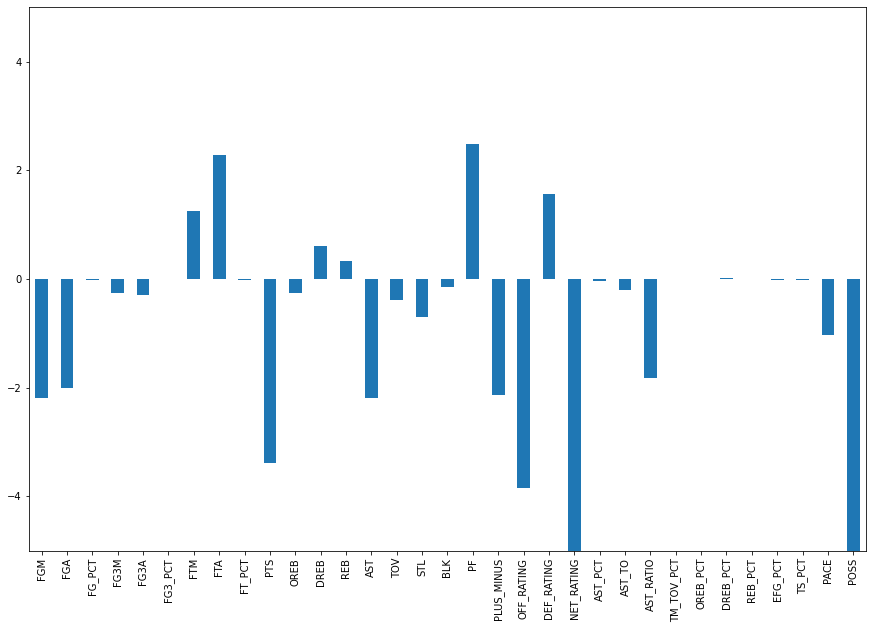

In [453]:
# parse to get regSeason stats of only those teams that made playoffs that season
playoffTeams = playoffStats['2001']['TEAM_NAME'].to_list()
regSeasonParsed = seasonStats['2001'][seasonStats['2001']['TEAM_NAME'].apply(lambda teamName: teamName in playoffTeams)]

# subtract regSeason stats from playoffs
pMinusR = playoffStats['2001'][standardStats + advancedStats] - regSeasonParsed[standardStats + advancedStats].reset_index(drop=True)

figH = plt.figure(figsize=(15,10))

pMinusR.mean().plot.bar()
plt.ylim([-5, 5])

(-5.0, 5.0)

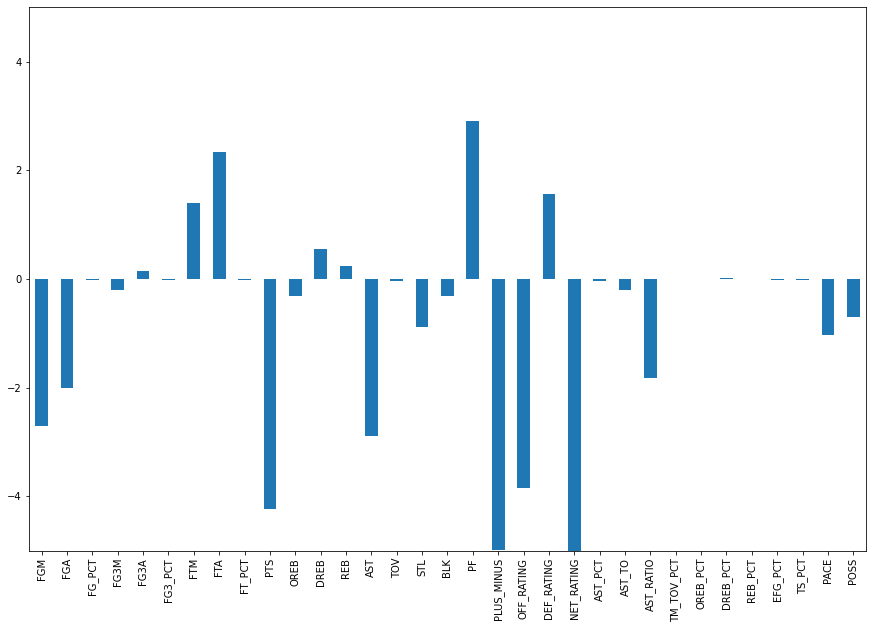

In [356]:
figH = plt.figure(figsize=(15,10))

pMinusR.mean().plot.bar()
plt.ylim([-5, 5])

In [382]:
from nba_api.stats.endpoints import leaguestandings

seasonStr = '2001-02'

temp = leaguestandings.LeagueStandings(season=seasonStr)
seasonStandings = temp.get_data_frames()[0]

filteredTeams = seasonStandings[seasonStandings['WinPCT'] >= 0.500]['TeamID'].to_list()
filteredTeams

[1610612758,
 1610612751,
 1610612759,
 1610612765,
 1610612747,
 1610612738,
 1610612742,
 1610612766,
 1610612750,
 1610612753,
 1610612757,
 1610612755,
 1610612761,
 1610612760,
 1610612762,
 1610612754,
 1610612749]

## Notes/Things Tried

In [297]:
# problem: only has data for back to 1997 season
from nba_api.stats.endpoints import leaguedashteamstats
seasonStr = '2013-14'

temp = leaguedashteamstats.LeagueDashTeamStats(season=seasonStr)
# leaguedashteamstats.LeagueDashTeamStats(team_id_nullable=teamIds['BOS'], season=seasonStr)
temp.get_data_frames()[0]

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
0,1610612737,Atlanta Hawks,82,38,44,0.463,3966.000,3061,6688,0.458,...,28,2,24,9,26,12,7,20,15,17
1,1610612738,Boston Celtics,82,25,57,0.305,3946.000,2996,6883,0.435,...,18,22,27,23,23,13,19,28,26,25
2,1610612751,Brooklyn Nets,82,44,38,0.537,3976.000,2931,6391,0.459,...,29,24,12,4,28,9,21,11,21,19
3,1610612766,Charlotte Bobcats,82,43,39,0.524,3981.000,2976,6730,0.442,...,16,16,1,29,8,21,1,9,23,16
4,1610612741,Chicago Bulls,82,48,34,0.585,3986.000,2843,6577,0.432,...,10,10,18,21,7,28,4,10,30,13
5,1610612739,Cleveland Cavaliers,82,33,49,0.402,3986.000,3036,6955,0.437,...,11,20,10,24,29,27,11,24,22,23
6,1610612742,Dallas Mavericks,82,49,33,0.598,3966.000,3249,6858,0.474,...,26,6,3,5,21,4,10,21,8,12
7,1610612743,Denver Nuggets,82,36,46,0.439,3950.985,3147,7042,0.447,...,2,12,28,18,4,24,30,7,9,20
8,1610612765,Detroit Pistons,82,29,53,0.354,3956.000,3182,7124,0.447,...,3,24,13,8,13,18,12,12,14,24
9,1610612744,Golden State Warriors,82,51,31,0.622,3966.000,3236,7005,0.462,...,5,7,22,13,10,10,22,26,10,4


In [8]:
def preprocess_team_stats(seasonStr, playoffsOrSeason):
    # Get per game stats using leaguedashteamstats
    # Then do a few preprocessing steps (eg. merge traditional and advanced stats into one df)
    
    # get regular season stats
    temp = leaguedashteamstats.LeagueDashTeamStats(season=seasonStr, per_mode_detailed='PerGame', season_type_all_star=playoffsOrSeason)
    standardDf = temp.get_data_frames()[0][['TEAM_NAME', 'TEAM_ID', 'GP'] + standardStats]

    temp = leaguedashteamstats.LeagueDashTeamStats(season=seasonStr, measure_type_detailed_defense='Advanced', season_type_all_star=playoffsOrSeason)
    advancedDf = temp.get_data_frames()[0][['TEAM_NAME', 'TEAM_ID', 'GP'] + advancedStats]

    # merge per-game and advanced into one table
    mergedDf = standardDf.merge(advancedDf[['TEAM_ID'] + advancedStats], on='TEAM_ID', how='right')
    mergedDf.index = mergedDf['TEAM_NAME'] # use team names as indices
    mergedDf = mergedDf.drop('TEAM_NAME', axis=1)
    mergedDf['POSS'] = mergedDf['POSS']/mergedDf['GP'] # get per game posessions
    
    return mergedDf

In [296]:
from nba_api.stats.endpoints import leaguedashteamstats

seasonStr = '2001-02'

regSeasonStats = preprocess_team_stats(seasonStr, playoffsOrSeason='Regular Season')
playoffStats = preprocess_team_stats(seasonStr, playoffsOrSeason='Playoffs')

In [298]:
# parse to get regSeason stats of only those teams that made playoffs that season
regSeasonParsed = regSeasonStats.loc[playoffStats.index.to_list()]

# subtract regSeason stats from playoffs
pMinusR = playoffStats - regSeasonParsed

(-5.0, 5.0)

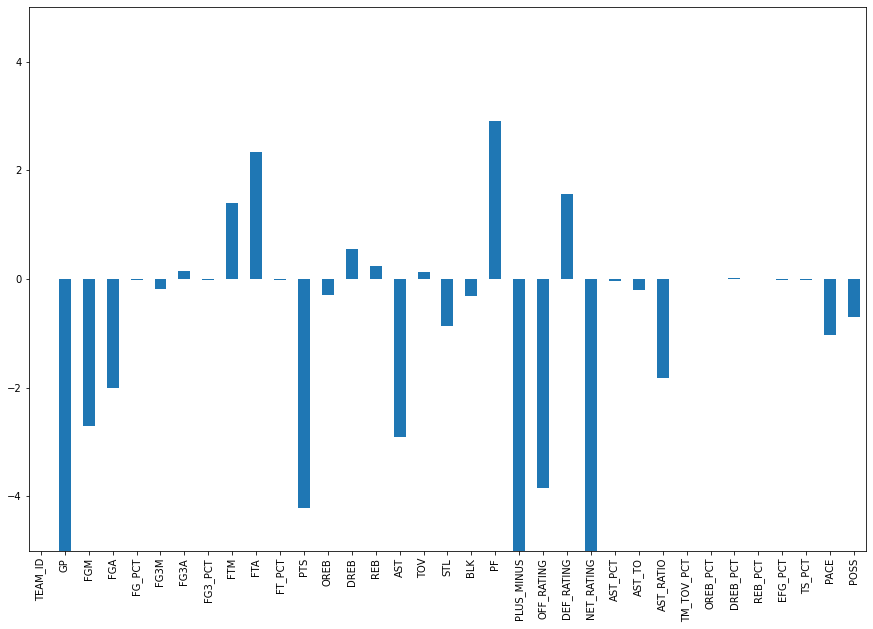

In [299]:
figH = plt.figure(figsize=(15,10))

pMinusR.mean().plot.bar()
plt.ylim([-5, 5])

In [49]:
pMinusR

,TEAM_ID,GP,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,...,AST_TO,AST_RATIO,TM_TOV_PCT,OREB_PCT,DREB_PCT,REB_PCT,EFG_PCT,TS_PCT,PACE,POSS
TEAM_NAME,,,,,,,,,,,,,,,,,,,,,
Atlanta Hawks,0,-77,-7.1,-10.1,-0.030,-1.5,0.6,-0.048,-0.9,-0.3,...,-0.07,-0.2,0.002,-0.082,0.019,-0.026,0.042,0.031,3.02,-7065
Boston Celtics,0,-58,-4.0,-5.6,-0.017,0.5,-0.5,0.017,1.5,2.3,...,0.46,2.9,-0.022,-0.038,0.008,-0.002,0.054,0.044,2.88,-5383
Brooklyn Nets,0,-78,-2.7,-10.4,0.028,0.0,-4.4,0.061,1.5,4.1,...,-0.16,-1.2,0.003,0.015,-0.072,-0.025,0.073,0.064,2.31,-7303
Chicago Bulls,0,-77,-5.3,3.3,-0.076,-0.2,8.0,-0.086,-5.5,-7.1,...,0.37,0.2,-0.039,-0.134,0.069,-0.051,-0.032,-0.041,6.63,-7286
Dallas Mavericks,0,-64,-3.0,-4.3,-0.012,2.7,4.1,0.030,1.6,2.1,...,0.45,-0.3,-0.043,-0.113,-0.013,-0.071,0.037,0.025,2.63,-5795
Denver Nuggets,0,-77,-2.3,-3.5,-0.007,-1.5,-4.5,0.004,3.3,4.2,...,0.10,1.1,0.003,0.017,0.077,0.038,0.042,0.038,-1.50,-7610
Golden State Warriors,0,-60,0.9,-0.3,0.011,-0.3,-2.1,0.011,-0.5,-0.5,...,0.37,2.3,-0.010,-0.002,0.069,0.043,0.049,0.042,-2.36,-6078
Memphis Grizzlies,0,-70,-3.7,-3.1,-0.026,1.6,3.1,0.012,2.9,4.0,...,0.55,1.6,-0.033,-0.001,0.043,0.010,0.003,-0.010,7.90,-6653
Miami Heat,0,-64,-1.6,0.5,-0.022,-2.7,-1.0,-0.066,0.0,0.2,...,0.29,0.2,-0.022,0.024,0.055,0.023,0.003,0.009,3.36,-5809


In [79]:
# game logs for each season - problem: lots of nans for stats that gameleaguefinder has data for

from nba_api.stats.endpoints import leaguegamelog

allTeams = list(teamIds.keys())
seasonStr = ['1983-84']

# for seasonStr in allSeasons:
    
#     for team in allTeams:

temp = leaguegamelog.LeagueGameLog(season=seasonStr, season_type_all_star='Regular Season')

allGamesDf = temp.get_data_frames()[0]
allGamesDf
# allGamesDf[allGamesDf['TEAM_ABBREVIATION']=='BOS'][standardStats].apply(np.mean)
# allGamesDf[allGamesDf['SEASON_ID']==]

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,21983,1610612738,BOS,Boston Celtics,0028300006,1983-10-28,BOS @ DET,L,240,40,...,NaN,47.0,23.0,NaN,NaN,NaN,38.0,121,-6,0
1,21983,1610612747,LAL,Los Angeles Lakers,0028300002,1983-10-28,LAL @ KCK,W,240,49,...,NaN,38.0,22.0,NaN,NaN,NaN,17.0,117,10,0
2,21983,1610612746,SDC,San Diego Clippers,0028300007,1983-10-28,SDC @ POR,L,240,34,...,NaN,31.0,19.0,NaN,NaN,NaN,31.0,93,-14,0
3,21983,1610612739,CLE,Cleveland Cavaliers,0028300008,1983-10-28,CLE vs. NYK,L,240,39,...,NaN,NaN,NaN,NaN,NaN,NaN,25.0,106,-7,0
4,21983,1610612754,IND,Indiana Pacers,0028300001,1983-10-28,IND @ MIL,L,240,35,...,NaN,53.0,27.0,NaN,NaN,NaN,NaN,83,-21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,21983,1610612757,POR,Portland Trail Blazers,0028300940,1984-04-15,POR @ SEA,L,240,39,...,NaN,37.0,24.0,NaN,NaN,NaN,28.0,103,-5,0
1882,21983,1610612756,PHX,Phoenix Suns,0028300942,1984-04-15,PHX @ LAL,W,240,53,...,NaN,39.0,36.0,NaN,NaN,NaN,27.0,123,9,0
1883,21983,1610612747,LAL,Los Angeles Lakers,0028300942,1984-04-15,LAL vs. PHX,L,240,44,...,NaN,42.0,24.0,NaN,NaN,NaN,26.0,114,-9,0
1884,21983,1610612751,NJN,New Jersey Nets,0028300941,1984-04-15,NJN @ BOS,L,240,49,...,NaN,38.0,26.0,NaN,NaN,NaN,22.0,111,-7,0


In [91]:
# per game stats of all times by year - problem: can't get Playoff stats, changing param doesn't do anything

from nba_api.stats.endpoints import teamyearbyyearstats

temp = teamyearbyyearstats.TeamYearByYearStats(team_id=teamIds['BOS'], per_mode_simple='PerGame', season_type_all_star='Playoffs')

temp.get_data_frames()[0]

,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,...,OREB,DREB,REB,AST,PF,STL,TOV,BLK,PTS,PTS_RANK
0,1610612738,Boston,Celtics,1946-47,60,22,38,0.367,0,5,...,0.0,0.0,0.0,7.8,20.0,0.0,0.0,0.0,60.1,11
1,1610612738,Boston,Celtics,1947-48,48,20,28,0.417,0,3,...,0.0,0.0,0.0,7.6,22.2,0.0,0.0,0.0,68.8,8
2,1610612738,Boston,Celtics,1948-49,60,25,35,0.417,0,5,...,0.0,0.0,0.0,18.9,23.0,0.0,0.0,0.0,76.6,9
3,1610612738,Boston,Celtics,1949-50,68,22,46,0.324,0,6,...,0.0,0.0,0.0,21.7,24.2,0.0,0.0,0.0,79.7,9
4,1610612738,Boston,Celtics,1950-51,69,39,30,0.565,0,2,...,0.0,0.0,0.0,22.9,27.3,0.0,0.0,0.0,85.2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,1610612738,Boston,Celtics,2018-19,82,49,33,0.598,4,3,...,9.8,34.7,44.5,26.3,20.4,8.6,12.8,5.3,112.4,14
73,1610612738,Boston,Celtics,2019-20,72,48,24,0.667,3,2,...,10.7,35.4,46.1,23.0,21.6,8.3,13.8,5.6,113.7,9
74,1610612738,Boston,Celtics,2020-21,72,36,36,0.500,7,4,...,10.6,33.6,44.3,23.5,20.4,7.7,14.1,5.3,112.6,16
75,1610612738,Boston,Celtics,2021-22,82,51,31,0.622,2,1,...,10.5,35.5,46.1,24.8,18.5,7.2,13.6,5.8,111.8,12


In [ ]:
import requests
import pandas as pd

url = 'https://stats.nba.com/stats/teamyearbyyearstats'
headers= {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36',
          'Referer': 'https://www.nba.com/'}
parsDict = {"LeagueID": None,
            "PerMode": 'Per Game',
            "SeasonType": 'Regular Season',
            "TeamID": teamIds['BOS']}

jsonData = requests.get(url, params=parsDict).json()


rows = jsonData['resultSets'][0]['rowSet']

# df = pd.DataFrame(rows, columns=columns)